In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
)

df = pd.read_csv("../data/wheat_yield_faostat_labeled.csv")
df.head()

,country,year,yield_kg_ha,low_yield
0,Afghanistan,1961,102.20,1
1,Afghanistan,1962,97.35,1
2,Afghanistan,1963,83.17,1
3,Afghanistan,1964,95.10,1
4,Afghanistan,1965,97.23,1


In [2]:
df = df.sort_values(["country", "year"]).copy()

df["yield_lag_1"] = df.groupby("country")["yield_kg_ha"].shift(1)
df["yield_lag_2"] = df.groupby("country")["yield_kg_ha"].shift(2)
df["yield_roll_3"] = (
    df.groupby("country")["yield_kg_ha"]
      .shift(1)
      .rolling(3)
      .mean()
)

# Keep only rows with available features
data = df.dropna(subset=["yield_lag_1", "yield_lag_2", "yield_roll_3"]).copy()

features = ["yield_lag_1", "yield_lag_2", "yield_roll_3", "year"]
X = data[features]
y = data["low_yield"].astype(int)
groups = data["country"]

X.shape, y.mean(), groups.nunique()

((6738, 4), np.float64(0.2309290590679727), 133)

In [3]:
def eval_predictions(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

In [4]:
gkf = GroupKFold(n_splits=5)

models = {
    "DummyMostFrequent": DummyClassifier(strategy="most_frequent"),
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500))
    ])
}

rows = []

for name, model in models.items():
    fold_metrics = []
    for train_idx, test_idx in gkf.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)

        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            # DummyMostFrequent doesn't have predict_proba reliably in all settings
            y_prob = np.zeros_like(y_test, dtype=float)

        fold_metrics.append(eval_predictions(y_test, y_prob))

    out = pd.DataFrame(fold_metrics).agg(["mean", "std"]).T
    rows.append({
        "model": name,
        **{f"{m}_mean": out.loc[m, "mean"] for m in out.index},
        **{f"{m}_std": out.loc[m, "std"] for m in out.index},
        "n_splits": 5,
        "n_groups": groups.nunique()
    })

results = pd.DataFrame(rows).sort_values("roc_auc_mean", ascending=False)
results

,model,roc_auc_mean,precision_mean,recall_mean,f1_mean,roc_auc_std,precision_std,recall_std,f1_std,n_splits,n_groups
1,LogReg,0.794125,0.646939,0.384123,0.480679,0.059739,0.107757,0.055762,0.067792,5,133
0,DummyMostFrequent,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,133


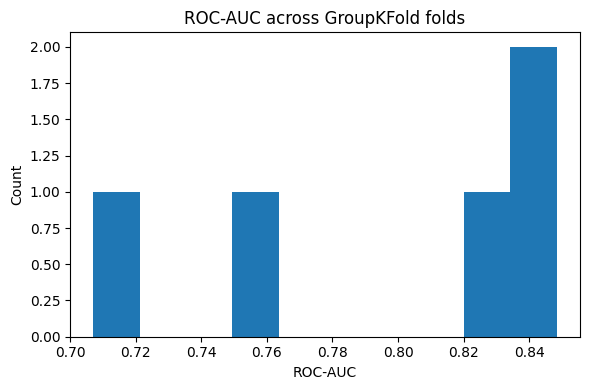

In [5]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])

fold_aucs = []
for train_idx, test_idx in gkf.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    logreg.fit(X_train, y_train)
    y_prob = logreg.predict_proba(X_test)[:, 1]
    fold_aucs.append(roc_auc_score(y_test, y_prob))

plt.figure(figsize=(6,4))
plt.hist(fold_aucs, bins=10)
plt.title("ROC-AUC across GroupKFold folds")
plt.xlabel("ROC-AUC")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [7]:
import os
os.makedirs("../outputs/tables", exist_ok=True)
os.makedirs("../outputs/figures", exist_ok=True)

results.to_csv("../outputs/tables/day2_groupkfold_results.csv", index=False)

plt.figure(figsize=(6,4))
plt.hist(fold_aucs, bins=10)
plt.title("ROC-AUC across GroupKFold folds")
plt.xlabel("ROC-AUC")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../outputs/figures/roc_auc_groupkfold.png")
plt.close()
